In [1]:
# ================================================
# Skeleton codes for HW5
# Read the skeleton codes carefully and put all your
# codes into function "reconstruct_from_binary_patterns"
# ================================================

import cv2
import numpy as np
from math import log, ceil, floor
import matplotlib.pyplot as plt
import pickle
import sys

In [2]:
scale_factor = 1.0
ref_white = cv2.resize(cv2.imread("images/pattern000.jpg", cv2.IMREAD_GRAYSCALE) / 255.0, (0,0), fx=scale_factor,fy=scale_factor)
ref_black = cv2.resize(cv2.imread("images/pattern001.jpg", cv2.IMREAD_GRAYSCALE) / 255.0, (0,0), fx=scale_factor,fy=scale_factor)
ref_avg   = (ref_white + ref_black) / 2.0
ref_on    = ref_avg + 0.05 # a threshold for ON pixels
ref_off   = ref_avg - 0.05 # add a small buffer region

h,w = ref_white.shape

# mask of pixels where there is projection
proj_mask = (ref_white > (ref_black + 0.05))

In [3]:
scan_bits = np.zeros((h,w), dtype=np.uint16)
# analyze the binary patterns from the camera
for i in range(0,15):
    # read the file
    patt_gray = cv2.resize(cv2.imread("images/pattern%03d.jpg"%(i+2), cv2.IMREAD_GRAYSCALE) / 255.0, (0,0), fx=scale_factor,fy=scale_factor)

    # mask where the pixels are ON
    on_mask = (patt_gray > ref_on) & proj_mask

    # this code corresponds with the binary pattern code
    bit_code = np.uint16(1 << i)
    # TODO: populate scan_bits by putting the bit_code according to on_mask
    scan_bits[on_mask] += bit_code
    patt = cv2.resize(cv2.imread("images/pattern001.jpg"), (0,0), fx=scale_factor,fy=scale_factor)

In [4]:
print("load codebook")
# the codebook translates from <binary code> to (x,y) in projector screen space
with open("binary_codes_ids_codebook.pckl","r") as f:
    binary_codes_ids_codebook = pickle.load(f)

load codebook


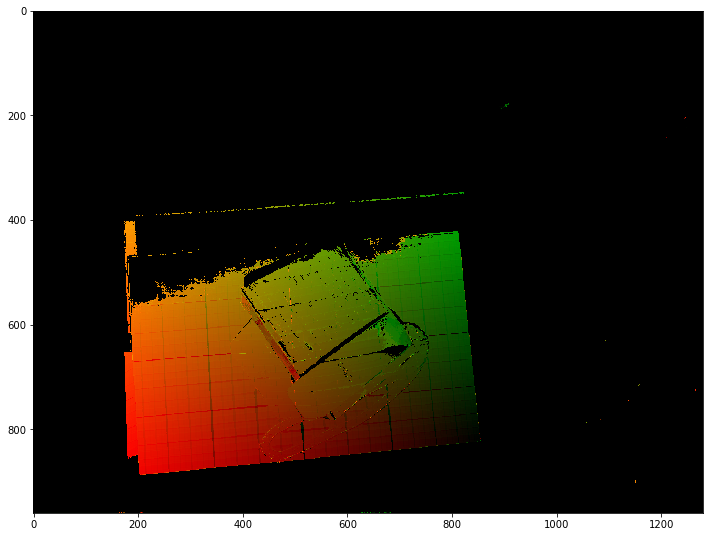

In [5]:
rgb = np.ndarray((h,w,3))

camera_points = []
projector_points = []
ref_rgb = cv2.imread("images/pattern001.jpg")
colors = []
for x in range(w):
    for y in range(h):
        if not proj_mask[y,x]:
            continue # no projection here
        if scan_bits[y,x] not in binary_codes_ids_codebook:
            continue # bad binary code
                    
        (x_p,y_p) = binary_codes_ids_codebook[scan_bits[y,x]]
        if x_p >= 1279 or y_p >= 799: # filter
            continue           
        camera_points.append([x/2,y/2]) 
        projector_points.append([x_p,y_p])
        
        color_pixel = ref_rgb[y,x]
        colors.append(color_pixel)

        rgb[y,x] = [x_p,y_p,0]
        camera_points
plt.figure(figsize=(12,12))
plt.imshow(rgb/np.max(rgb))
plt.show()
        # TODO: use binary_codes_ids_codebook[...] and scan_bits[y,x] to
        # TODO: find for the camera (x,y) the projector (p_x, p_y).
        # TODO: store your points in camera_points and projector_points
        # IMPORTANT!!! : due to differences in calibration and acquisition - divide the camera points by 2

In [6]:
bgr = rgb.copy()
bgr[:, :, 0] = rgb[:, :, 2]/max(1,np.max(rgb[:, :, 2]))
bgr[:, :, 2] = rgb[:, :, 0]/max(1,np.max(rgb[:, :, 0]))
bgr[:, :, 1] = rgb[:, :, 1]/max(1,np.max(rgb[:, :, 1]))
# bgr = np.uint8(bgr/np.max(bgr)*255)
bgr = np.uint8(bgr*255)
cv2.imwrite('correspondence.jpg', bgr)

True

In [7]:
colors = np.array(colors).reshape(-1,3)
colors = colors.reshape(colors.shape[0],1,3)

In [8]:
camera_x = np.array(zip(*camera_points)[0])
camera_y = np.array(zip(*camera_points)[1])
camera_pts = np.ndarray((camera_x.shape[0],1,2))
camera_pts[:,0,0] = camera_x
camera_pts[:,0,1] = camera_y

projector_x = np.array(zip(*projector_points)[0])
projector_y = np.array(zip(*projector_points)[1])
projector_pts = np.ndarray((projector_x.shape[0],1,2))
projector_pts[:,0,0] = projector_x
projector_pts[:,0,1] = projector_y

In [9]:
# now that we have 2D-2D correspondances, we can triangulate 3D points!

# load the prepared stereo calibration between projector and camera
with open("stereo_calibration.pckl","r") as f:
    d = pickle.load(f)
    camera_K    = d['camera_K']
    camera_d    = d['camera_d']
    projector_K = d['projector_K']
    projector_d = d['projector_d']
    projector_R = d['projector_R']
    projector_t = d['projector_t']

In [10]:
points_3d = np.ndarray(3,)

# TODO: use cv2.undistortPoints to get normalized points for camera, use camera_K and camera_d
# TODO: use cv2.undistortPoints to get normalized points for projector, use projector_K and projector_d

# TODO: use cv2.triangulatePoints to triangulate the normalized points
# TODO: use cv2.convertPointsFromHomogeneous to get real 3D points
# TODO: name the resulted 3D points as "points_3d"
camera = cv2.undistortPoints(camera_pts, camera_K, camera_d)
projector = cv2.undistortPoints(projector_pts, projector_K, projector_d)
projMatr = np.hstack((projector_R,projector_t))
triang = cv2.triangulatePoints(np.eye(3,4), projMatr, camera, projector)

In [11]:
points_3d = cv2.convertPointsFromHomogeneous(triang.T)
mask = (points_3d[:,:,2] > 200) & (points_3d[:,:,2] < 1400)
# print("points_3d before: ", points_3d.shape)
p = np.ndarray((points_3d[mask].shape[0], 1, 3),np.float64)
p[:,0,:] = points_3d[mask]
points_3d = p


In [12]:
def write_3d_points(points_3d):
    
    # ===== DO NOT CHANGE THIS FUNCTION =====
    
    print("write output point cloud")
    print(points_3d.shape)
    output_name = "output.xyz"
    with open(output_name,"w") as f:
        for p in points_3d:
            f.write("%d %d %d\n"%(p[0,0],p[0,1],p[0,2]))

write_3d_points(points_3d)

write output point cloud
(237381, 1, 3)


In [13]:
colors = colors[mask]
output_color = np.hstack([points_3d[:,0,:], colors])

In [14]:
def write_color(output_color):
    
    # ===== DO NOT CHANGE THIS FUNCTION =====
    
    output_name = "output_color.xyz"
    with open(output_name,"w") as f:
        for p in output_color:
            f.write("%d %d %d %d %d %d\n"%(p[0],p[1],p[2],p[5],p[4],p[3]))

write_color(output_color)